In [28]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [29]:
# from model.resnet import *
from model.effnet import *
from model.unet import *
from utils.metrics import *
from utils.losses import *

import os
import pandas as pd
import warnings
import numpy as np
from skimage import io, transform
from rasterio.features import rasterize
from shapely.ops import cascaded_union, unary_union
from shapely.geometry import Polygon
from shapely.errors import ShapelyDeprecationWarning
from torch.utils.data import Dataset
import pickle
import albumentations as A

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, utils, datasets, models
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
from pytorch_metric_learning import losses
import copy

from collections import OrderedDict, defaultdict
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import timm
from torch.cuda import amp
from tqdm import tqdm
import torch.optim as optim
from time import time

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore")

In [30]:
# Check file or directory is exist

dataset_path = 'input/forestnet'

train_df = pd.read_csv(f'{dataset_path}/ForestNetDataset/train.csv')
val_df = pd.read_csv(f'{dataset_path}/ForestNetDataset/val.csv')
test_df = pd.read_csv(f'{dataset_path}/ForestNetDataset/test.csv')

train_df.head()

,label,merged_label,latitude,longitude,year,example_path
0,Timber plantation,Plantation,4.430849,96.101634,2014,examples/4.430849118860583_96.1016343478138
1,Other,Other,1.332341,109.374229,2012,examples/1.3323406178609702_109.37422873130464
2,Grassland shrubland,Grassland shrubland,-1.720266,115.006996,2016,examples/-1.720266384577504_115.00699582064485
3,Small-scale agriculture,Smallholder agriculture,-2.248346,104.135786,2011,examples/-2.248346072674411_104.1357857482906
4,Other large-scale plantations,Plantation,-2.100800,113.022376,2008,examples/-2.100800102991412_113.0223763234016


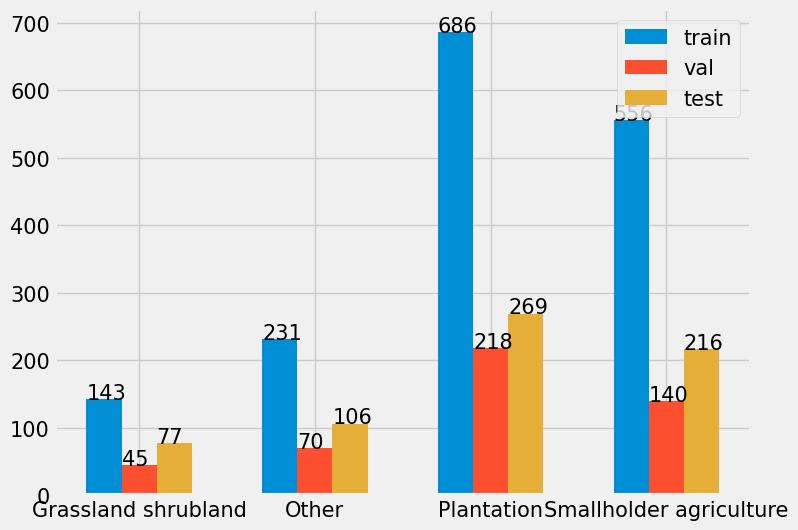

In [31]:
# Plot distribution of data
train_df_class = train_df.groupby(['merged_label']).size().to_frame('train').reset_index()
val_df_class = val_df.groupby(['merged_label']).size().to_frame('val').reset_index()
test_df_class = test_df.groupby(['merged_label']).size().to_frame('test').reset_index()

plt.figure(figsize=(8, 6))
x_axis = np.arange(len(train_df_class['merged_label']))
index = [[train_df_class,'train',-0.2],[val_df_class,'val',0],[test_df_class,'test',0.2]]
for i in index:
  df = i[0]
  bars = plt.bar(x_axis + i[2], df[i[1]] , width=0.2, label=i[1])
  for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x(), yval + .005, yval)
plt.xticks(x_axis,train_df_class['merged_label'])
plt.legend()
plt.show()

In [32]:
class ForestDataset(Dataset):
    """Forest dataset."""

    def __init__(self, csv_file_to_df, root_dir=f'{dataset_path}/ForestNetDataset', transform=None, types="classifier"):
        self.csv = csv_file_to_df
        self.root_dir = root_dir
        self.transform = transform
        self.label_to_int = {'Grassland shrubland':0, 'Other':1, 'Plantation':2, 'Smallholder agriculture':3}
        self.types = types

    def __len__(self):
        return len(self.csv)
    
    def poly_from_utm(self, polygon):
        poly_pts = []

        poly = unary_union(polygon)
        for i in np.array(poly.exterior.coords):

            poly_pts.append(tuple(i))

        new_poly = Polygon(poly_pts)
        return new_poly

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.csv.iloc[idx, 0]
        merged_label = self.csv.iloc[idx, 1]
        lat = self.csv.iloc[idx, 2]
        long = self.csv.iloc[idx, 3]
        year = self.csv.iloc[idx, 4]
        folder = self.csv.iloc[idx, 5]
        
        ## Load the image and auxiliary
        image_path = f'{self.root_dir}/{folder}/images/visible/composite.png'.replace(' ', '')
        image = io.imread(image_path)

        slope_path = f'{self.root_dir}/{folder}/auxiliary/gfc.npy'.replace(' ', '')
        slope = np.load(slope_path)
          
        ## Get the segmentation map
        segmentation_path = f'{self.root_dir}/{folder}/forest_loss_region.pkl'.replace(' ', '')
        with open(segmentation_path, 'rb') as f:
            data = pickle.load(f)
      
        nx, ny = 332, 332
        xy_array = np.empty((0,2))
        if data.geom_type == 'Polygon':
            data = [data]
        elif data.geom_type == 'Multipolygon':
            data = list(data)
              
        poly_shp = []
        for poly_verts in data:
            poly_shp.append(self.poly_from_utm(poly_verts))

        mask = rasterize(shapes=poly_shp, out_shape=(332,332))
        seg = np.array(mask)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
          
        image = torch.from_numpy(image).type(torch.float)
        image = image.permute(2, 0, 1)
        seg = torch.from_numpy(seg).type(torch.uint8)
        slope = torch.from_numpy(slope).type(torch.float)

        merged_label = self.label_to_int[merged_label]

        image = image[:, 86:246, 86:246]
        seg = seg[86:246, 86:246]
        slope = slope[86:246, 86:246]
        if self.types == "classifier":
            return image, seg, merged_label
        else:
            return image, seg, merged_label
 

In [33]:
# Initialization several arguments for training
BATCH_SIZE = 16
DEVICE = device = "cuda:0" if torch.cuda.is_available() else "cpu"
LR = 0.001
EPOCH = 20
nbClass = 4

In [34]:
# Load Dataset and Create DataLoader For Classification
train_dataset = ForestDataset( csv_file_to_df=train_df)
val_dataset = ForestDataset( csv_file_to_df=val_df)
test_dataset = ForestDataset( csv_file_to_df=test_df)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}

# Load Dataset and Create DataLoader For Representation Learning
train_dataset_re = ForestDataset( csv_file_to_df=train_df, types="projection")
val_dataset_re = ForestDataset( csv_file_to_df=val_df, types="projection")
test_dataset_re = ForestDataset( csv_file_to_df=test_df, types="projection")
trainloader_re = torch.utils.data.DataLoader(train_dataset_re, batch_size=BATCH_SIZE,shuffle=True)
valloader_re = torch.utils.data.DataLoader(val_dataset_re, batch_size=BATCH_SIZE,shuffle=False)
testloader_re = torch.utils.data.DataLoader(test_dataset_re, batch_size=BATCH_SIZE,shuffle=False)
dataloaders_re = {'train': trainloader_re, 'val':valloader_re}

In [35]:
dataiter = iter(trainloader)
images, seg, labels = next(dataiter)

print('images shape on PyTroch : ', images.size())
# print('slope shape on PyTroch : ', slope.size())
print('labels shape on PyTroch : ', labels.size())

images shape on PyTroch :  torch.Size([16, 3, 160, 160])
labels shape on PyTroch :  torch.Size([16])


In [36]:
sample = next(iter(trainloader_re))[1]
print(sample.shape)

sample_target = next(iter(valloader_re))[1]
print(sample_target.shape)

torch.Size([16, 160, 160])
torch.Size([16, 160, 160])


In [37]:
def show_curves(acc_dict, loss_dict):
    fig = plt.figure(figsize=(22,8))
    train_score,eval_score = acc_dict.values()
    train_score=list(map(float,train_score))
    eval_score=list(map(float,eval_score))
    ax = plt.figure().gca()
    plt.plot(train_score)
    plt.plot(eval_score)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning curves')
    plt.show()
    
    train_loss, eval_loss = loss_dict.values()
    train_loss=list(map(float,train_loss))
    eval_loss=list(map(float,eval_loss))
    ax = plt.figure().gca()
    plt.plot(train_loss)
    plt.plot(eval_loss)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.show()

In [38]:
dataset_sizes = {'train':len(train_df), 'val':len(val_df)}
acc_dict = {'train':[], 'val':[]}
loss_dict= {'train':[], 'val':[]}

## Multimodal SuperCon using UNet

In [39]:
def train_model_SCL(model, criterion, optimizer, scheduler, num_epochs, dataloaders):
    start = time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    history = defaultdict(list)
    scaler = amp.GradScaler()

    for step, epoch in enumerate(range(1,num_epochs+1)):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        for phase in ['train','val']:
            if(phase == 'train'):
                model.train() 
            else:
                model.eval()
            
            running_loss = 0.0
            
            for inputs,seg,labels in dataloaders[phase]:
                inputs = inputs.to(device)
                seg=seg.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    with amp.autocast(enabled=True):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        loss = loss / 4
                    
                    if phase == 'train':
                        scaler.scale(loss).backward()

                    if phase == 'train' and (step + 1) % 4 == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        scheduler.step()
                        optimizer.zero_grad()

                running_loss += loss.item()*inputs.size(0)
            
            epoch_loss = running_loss/dataset_sizes[phase]            
            history[phase + ' loss'].append(epoch_loss)

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            if phase=='val' and epoch_loss <= best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    end = time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss ",best_loss)

    model.load_state_dict(best_model_wts)
    return model, history

In [42]:
criterion_class = FocalLoss()
criterion_seg = DiceLoss()

In [43]:
dataset_sizes = {'train':len(train_df), 'val':len(val_df)}

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()  

            running_loss = 0.0
            running_acc_seg = 0.0
            running_acc_class = 0.0

            for images, seg, labels in dataloaders[phase]:
                images = images.to(device)
                seg = seg.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs, out_class = model(images)
                    loss_seg = criterion_seg(outputs, torch.unsqueeze(seg.float(), dim=1))
                    loss_class = criterion_class(out_class, labels)
                    loss = loss_seg + loss_class

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                m1, m0, m_avg = get_acc_binseg(outputs, torch.unsqueeze(seg.float(), dim=1))
                running_acc_seg += m_avg.item()
                running_acc_class += get_acc_class(out_class, labels).item()
                running_loss += loss.item()
                
            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc_seg = running_acc_seg / len(dataloaders[phase])
            epoch_acc_class = running_acc_class / len(dataloaders[phase])

            print('{} Loss: {:.4f} Acc Seg: {:.4f} Acc Class: {:.4f}'.format(
                phase, epoch_loss, epoch_acc_seg, epoch_acc_class))
            acc_seg_dict[phase].append(epoch_acc_seg)
            acc_class_dict[phase].append(epoch_acc_class)
            loss_dict[phase].append(epoch_loss)

            if phase == 'val' and epoch_acc_class > best_acc:
                best_acc = epoch_acc_class
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [44]:
"""Training UNet Classifier + Segmentation"""

unet_model = UNet(3,1,"classification")
unet_model = unet_model.to(device)

In [45]:
optimizer = torch.optim.AdamW(unet_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
acc_seg_dict = {'train':[], 'val':[]}
acc_class_dict = {'train':[], 'val':[]}
loss_dict= {'train':[], 'val':[]}

unet_classifier_segmentation = train_model(unet_model, optimizer, scheduler, num_epochs=15)

Epoch 1/15
----------
train Loss: 1.5390 Acc Seg: 0.6008 Acc Class: 0.4134
val Loss: 1.3955 Acc Seg: 0.5993 Acc Class: 0.4299
Epoch 2/15
----------
train Loss: 1.2087 Acc Seg: 0.6631 Acc Class: 0.4722
val Loss: 1.1816 Acc Seg: 0.6479 Acc Class: 0.5060
Epoch 3/15
----------
train Loss: 1.0730 Acc Seg: 0.6806 Acc Class: 0.5606
val Loss: 1.0968 Acc Seg: 0.6672 Acc Class: 0.5306
Epoch 4/15
----------
train Loss: 0.9878 Acc Seg: 0.6937 Acc Class: 0.6275
val Loss: 1.1117 Acc Seg: 0.6698 Acc Class: 0.5549
Epoch 5/15
----------
train Loss: 0.9747 Acc Seg: 0.6987 Acc Class: 0.6126
val Loss: 1.2638 Acc Seg: 0.6614 Acc Class: 0.4655
Epoch 6/15
----------
train Loss: 0.9501 Acc Seg: 0.6936 Acc Class: 0.6262
val Loss: 1.0848 Acc Seg: 0.5770 Acc Class: 0.6097
Epoch 7/15
----------
train Loss: 0.9067 Acc Seg: 0.7002 Acc Class: 0.6473
val Loss: 0.9347 Acc Seg: 0.6810 Acc Class: 0.6155
Epoch 8/15
----------
train Loss: 0.8741 Acc Seg: 0.7029 Acc Class: 0.6640
val Loss: 0.9130 Acc Seg: 0.6938 Acc Class:

In [46]:
def show_curves(acc_dict, loss_dict):
    fig = plt.figure(figsize=(22,8))
    train_score,eval_score = acc_dict.values()
    train_score=list(map(float,train_score))
    eval_score=list(map(float,eval_score))
    ax = plt.figure().gca()
    plt.plot(train_score)
    plt.plot(eval_score)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning curves')
    plt.show()
    
    train_loss, eval_loss = loss_dict.values()
    train_loss=list(map(float,train_loss))
    eval_loss=list(map(float,eval_loss))
    ax = plt.figure().gca()
    plt.plot(train_loss)
    plt.plot(eval_loss)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.show()

<Figure size 2200x800 with 0 Axes>

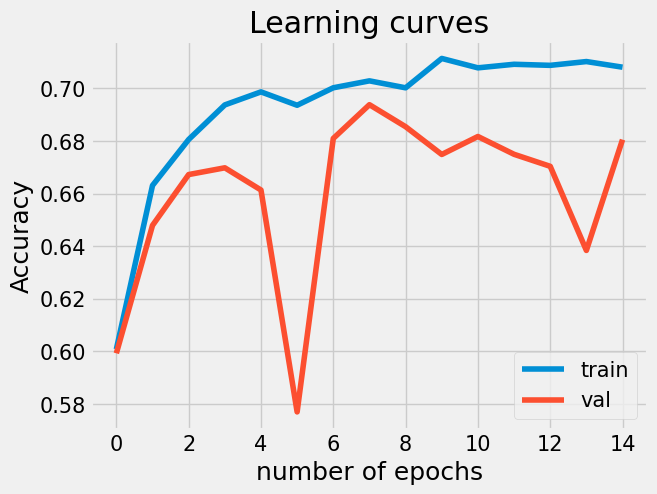

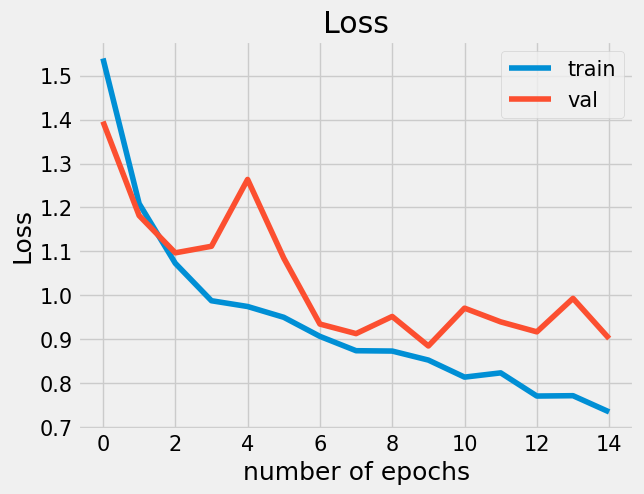

In [47]:
show_curves(acc_seg_dict, loss_dict)

<Figure size 2200x800 with 0 Axes>

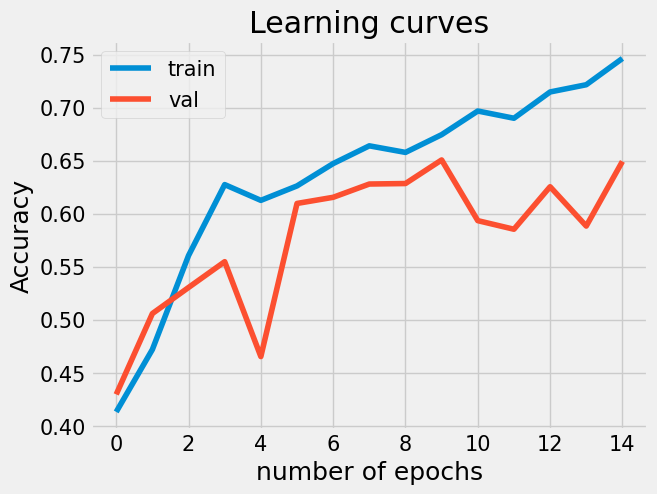

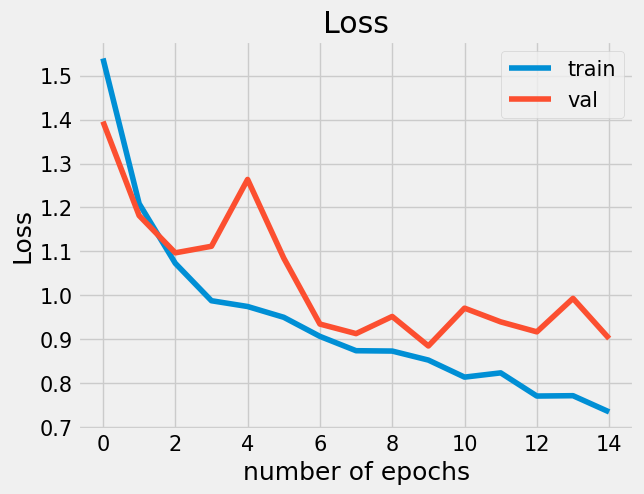

In [48]:
show_curves(acc_class_dict, loss_dict)

In [53]:
def test(model): 
    running_accuracy = 0 
    total = 0 
 
    with torch.no_grad(): 
        for images, seg, labels in testloader: 
            images = images.to(device)
            seg = seg.to(device)
            labels = labels.to(device)

            outputs, out_class = model(images)

            total += labels.size(0) 
            running_accuracy += get_acc_class(out_class, labels).item()
 
        print('Accuracy of the model based on the test set is: %d %%' % (100 * running_accuracy / len(testloader)))  

In [54]:
test(unet_classifier_segmentation)

Accuracy of the model based on the test set is: 60 %
